In [69]:
#Import Libraries
import subprocess
import re
import pandas as pd
import os
import collections
import scipy.stats
import numpy as np
import scipy
import csv
import math
import time
import seaborn as sns
import statsmodels.api as sm
import joblib
import random
import extra_funcs_TO

from functools import reduce
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.tools.plotting import table
from scipy import interp
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_classification


from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, LeaveOneOut, train_test_split, StratifiedShuffleSplit, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, auc, roc_curve, precision_recall_curve, f1_score, classification_report, make_scorer, balanced_accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D

## Gene_Exprs, in particular PC

In [70]:
dset=pd.read_csv ("clintab_GMQL/gencode.gene.info.v22.tsv", delimiter='\t')
gruppo=dset.groupby(['gene_type'])
proteingroup=gruppo.get_group('protein_coding')
lista1=set(proteingroup['gene_id'])
#len(proteingroup)

In [71]:
dset_rna_res=pd.read_csv("clintab_GMQL/gene_exprs/res/res_new.csv", delimiter='\t')
dset_rna_senl=pd.read_csv("clintab_GMQL/gene_exprs/sl_32/sl_new.csv", delimiter='\t')
dset_rna_sens=pd.read_csv("clintab_GMQL/gene_exprs/ss_32/ss_new.csv", delimiter='\t')

In [72]:
#24 geni
lista=['ADAM12','BCCIP','BID','BLM','BMPR1B','CA9','CTBP2','CUZD1','DLL1','ELAVL1','FGFR2','FURIN',
       'GHSR','HTRA1','IQGAP1','PARK2','RECK','RNASET2','STOML2','TNFSF10','TPM2','UNC45A','UNC93A','URI1']
type(lista)

list

lista=['BID','CA9','CTBP2','DLL1','ELAVL1','HTRA1', 'RNASET2','URI1']
type(lista)

In [73]:
dset_res = dset_rna_res[dset_rna_res.ensemble_id.isin(lista1)]
protein_coding_res=pd.DataFrame(dset_res)
resistant=protein_coding_res[protein_coding_res.gene_symbol.isin(lista)]
res=pd.DataFrame(resistant)
#res.head(25)

In [74]:
dset_senl = dset_rna_senl[dset_rna_senl.ensemble_id.isin(lista1)]
protein_coding_senl=pd.DataFrame(dset_senl)
sensitive_l=protein_coding_senl[protein_coding_senl.gene_symbol.isin(lista)]
senl=pd.DataFrame(sensitive_l)
#senl.head()

In [75]:
dset_sens = dset_rna_sens[dset_rna_sens.ensemble_id.isin(lista1)]
protein_coding_sens=pd.DataFrame(dset_sens)
sensitive_s=protein_coding_sens[protein_coding_sens.gene_symbol.isin(lista)]
sens=pd.DataFrame(sensitive_s)
#sens.head(9)

In [76]:
resdf=res.pivot(index="patient", columns="gene_symbol", values="fpkm")
genes = resdf.columns.tolist()
senldf=senl.pivot(index="patient", columns="gene_symbol", values="fpkm")
genes = senldf.columns.tolist()
sensdf=sens.pivot(index="patient", columns="gene_symbol", values="fpkm")
genes = sensdf.columns.tolist()

In [77]:
def pearson(A):
    Pearson=np.corrcoef(A)
    
    Pearson=np.nan_to_num(Pearson)
    return Pearson

#resdf_pearson=pearson(resdf.values)
resdf_pearson=pearson(resdf.values.transpose())
resdf_pearson_df=pd.DataFrame(resdf_pearson, index=resdf.columns, columns=resdf.columns)

In [64]:
#resdf.values.transpose()
resdf_pearson_df.head()

gene_symbol,ADAM12,BCCIP,BID,BLM,BMPR1B,CA9,CTBP2,CUZD1,DLL1,ELAVL1,...,IQGAP1,PARK2,RECK,RNASET2,STOML2,TNFSF10,TPM2,UNC45A,UNC93A,URI1
gene_symbol,,,,,,,,,,,,,,,,,,,,,
ADAM12,1.000000,-0.439356,0.094588,0.026163,-0.098068,-0.051021,-0.157479,-0.171009,0.181662,-0.157972,...,0.474745,-0.061461,0.668700,-0.251248,-0.321399,0.073363,0.336798,0.046189,-0.084362,-0.181572
BCCIP,-0.439356,1.000000,-0.081106,0.259518,0.152621,-0.072202,0.397248,0.251869,0.137811,0.320861,...,-0.246077,0.096452,-0.283042,0.029934,0.195738,-0.188175,-0.226606,-0.045214,0.076845,0.055534
BID,0.094588,-0.081106,1.000000,-0.131366,-0.271782,-0.170474,-0.006583,-0.197302,-0.196437,-0.204571,...,0.028639,-0.045874,0.033207,-0.126839,0.073371,0.019079,0.144197,0.063128,-0.124015,0.140201
BLM,0.026163,0.259518,-0.131366,1.000000,0.006580,-0.181977,0.076560,0.018889,0.149627,0.379730,...,0.245571,-0.193306,-0.124008,-0.085318,0.088043,-0.000636,-0.076403,0.246899,0.055728,-0.013940
BMPR1B,-0.098068,0.152621,-0.271782,0.006580,1.000000,-0.022639,0.135211,0.087922,0.185115,0.013732,...,0.101217,0.382123,-0.024554,0.016244,0.082205,-0.119537,-0.020107,-0.135737,-0.039664,-0.093882


In [78]:
for i in range(resdf_pearson.shape[0]):
    for j in range(resdf_pearson.shape[1]):
        if resdf_pearson[i,j]<abs(0.3):
            resdf_pearson[i,j]=0

In [67]:
resdf_pearson_df.head()

gene_symbol,ADAM12,BCCIP,BID,BLM,BMPR1B,CA9,CTBP2,CUZD1,DLL1,ELAVL1,...,IQGAP1,PARK2,RECK,RNASET2,STOML2,TNFSF10,TPM2,UNC45A,UNC93A,URI1
gene_symbol,,,,,,,,,,,,,,,,,,,,,
ADAM12,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.181662,0.000000,...,0.474745,0.000000,0.6687,0.0,0.000000,0.0,0.336798,0.000000,0.0,0.000000
BCCIP,0.0,1.000000,0.0,0.259518,0.152621,0.0,0.397248,0.251869,0.137811,0.320861,...,0.000000,0.000000,0.0000,0.0,0.195738,0.0,0.000000,0.000000,0.0,0.000000
BID,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.144197,0.000000,0.0,0.140201
BLM,0.0,0.259518,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.149627,0.379730,...,0.245571,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.246899,0.0,0.000000
BMPR1B,0.0,0.152621,0.0,0.000000,1.000000,0.0,0.135211,0.000000,0.185115,0.000000,...,0.101217,0.382123,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [79]:
List=[('Source','Target','Weight')]
for source in resdf_pearson_df.index.values:
    for target in resdf_pearson_df.index.values:
        if resdf_pearson_df[source][target]!=0:
            List.append((target,source,resdf_pearson_df[source][target]))
List1=pd.DataFrame(List)
List1.to_csv(r'edge_list24_bis.csv', index=None, header=None)

In [ ]:
import networkx as nx
graph=nx.from_numpy_matrix(resdf_pearson)
nx.draw(graph)

In [ ]:
column=res['gene_symbol']
column.head()

In [9]:
sendf=pd.concat([senldf, sensdf])

In [10]:
resdf_median = resdf.median(0)
sendf_median = sendf.median(0)

In [11]:
pvalues = []
for gene in tqdm(genes):
    try:
        gene_pvalue = scipy.stats.mannwhitneyu(sendf[gene],resdf[gene]).pvalue
    except Exception:
        gene_pvalue = 1
       
    pvalues.append(gene_pvalue)
       
pvalues = pd.DataFrame({
    "gene": genes,
    "resistant_median": resdf_median.values,
    "sensitive_median": sendf_median.values,
    #"sensitive_long_median": senldf_median.values,
    #"sensitive_short_median": sensdf_median.values,
    "mannwhiteney_pvalue": pvalues
})

pvalues.head()

100%|██████████| 8/8 [00:00<00:00, 1261.54it/s]


,gene,resistant_median,sensitive_median,mannwhiteney_pvalue
0,BID,7.786911,8.287398,0.359774
1,CA9,6.021777,4.424864,0.389906
2,CTBP2,10.437666,10.767239,0.197859
3,DLL1,0.617823,0.708018,0.417608
4,ELAVL1,14.554354,14.532408,0.422787


In [12]:
listageni=pvalues['gene'].values
listageni

array(['BID', 'CA9', 'CTBP2', 'DLL1', 'ELAVL1', 'HTRA1', 'RNASET2',
       'URI1'], dtype=object)

In [ ]:
sns.set(style="whitegrid", font_scale=1.5)
data = pd.DataFrame(columns=["Values", "Class", "gene"])

for g in listageni[:]:
    #data = pd.DataFrame(columns=["Values", "Class", "gene"])
    for row in resdf[g]:
        data = data.append({"Values":row,"Class":"Res", "gene":g}, ignore_index=True)
    for row in sendf[g]:
        data = data.append({"Values":row,"Class":"Sen", "gene":g}, ignore_index=True)

palette = ["violet", "skyblue"]   
plt.figure()
plt.xticks(rotation="vertical")
sns.violinplot(data=data[data["gene"].isin(listageni)], x="gene", y="Values", hue="Class", palette=palette, saturation=0.75, alpha=0.7, split=True)
plt.legend(loc="upper left")
plt.figure()
#plt.xticks(rotation="vertical")
#sns.violinplot(data=data[data["gene"].isin(listageni[4:])], x="gene", y="Values", hue="Class", palette=palette, saturation=0.75, alpha=0.7, split=True)
#plt.legend(loc="upper left")
    #plt.title(g)
#plt.savefig('enrichment/violinplot_tot.png'.format(g))

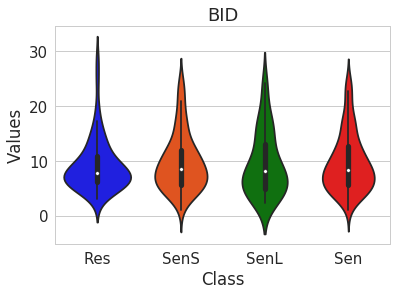

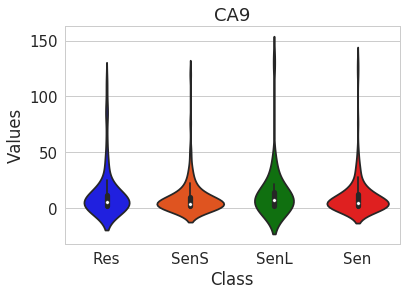

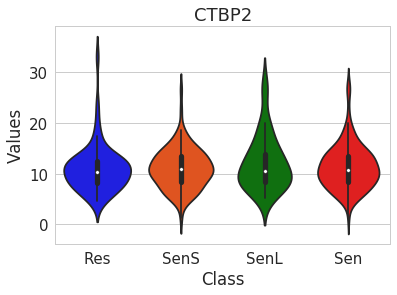

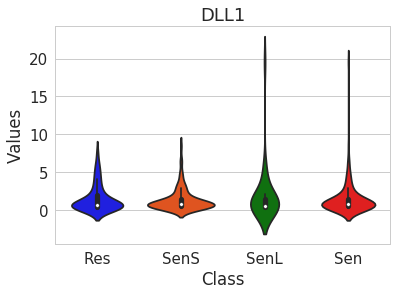

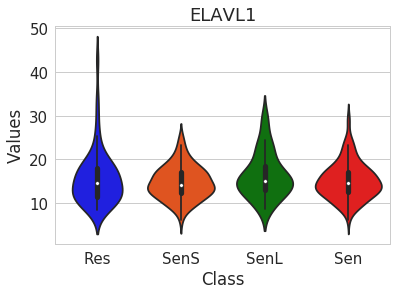

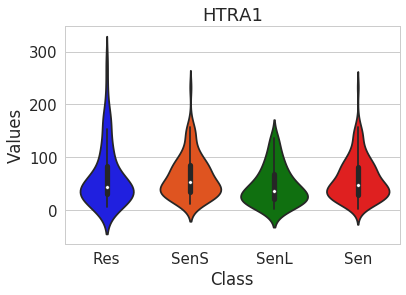

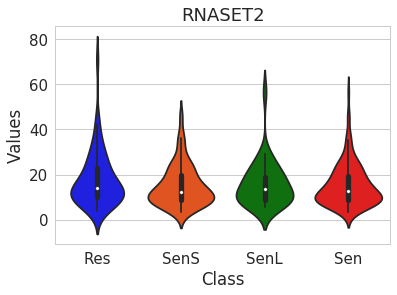

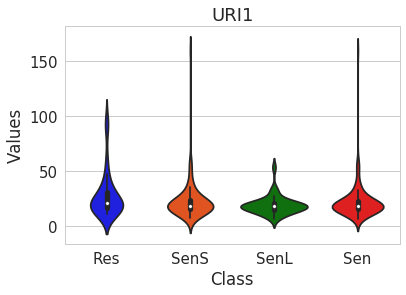

In [34]:
sns.set(style="whitegrid", font_scale=1.5)
#current_palette = sns.color_palette()
#sns.palplot(current_palette)

for g in listageni[:]:
    data = pd.DataFrame(columns=["Values", "Class"])
    for row in resdf[g]:
        data = data.append({"Values":row,"Class":"Res"}, ignore_index=True)
    for row in sensdf[g]:
        data = data.append({"Values":row,"Class":"SenS"}, ignore_index=True)
    for row in senldf[g]:
        data = data.append({"Values":row,"Class":"SenL"}, ignore_index=True)
    for row in sendf[g]:
        data = data.append({"Values":row,"Class":"Sen"}, ignore_index=True)

        
    palette = ["blue", "orangered", "green", "red"]
    plt.figure()
    sns.violinplot(data=data, x="Class", y="Values", palette=palette, saturation=0.75, alpha=0.7, split=True)
    plt.title(g)
    #plt.savefig('enrichment/violinplot{}.png'.format(g), figsize=(24,16))

In [ ]:
res=senldf['CTBP2']
sen=sensdf['CTBP2']

In [ ]:
from scipy import stats
stats.ttest_ind(res, sen, equal_var=False)

In [ ]:
stats.ks_2samp(res, sen)

## miRNA

In [ ]:
dset_res=pd.read_csv("clintab_GMQL/miRNA/res_miRNA/res_miRNA_new.csv", delimiter='\t')
dset_senl=pd.read_csv("clintab_GMQL/miRNA/sl_miRNA_32/sl_miRNA_new.csv", delimiter='\t')
dset_sens=pd.read_csv("clintab_GMQL/miRNA/ss_miRNA_32/ss_miRNA_new.csv", delimiter='\t')

In [ ]:
lista=['hsa-mir-34a','hsa-mir-34c','hsa-mir-200b','hsa-mir-200c']
type(lista)

In [ ]:
ds_sens = dset_sens[dset_sens.mirna_id.isin(lista)]
sens=pd.DataFrame(ds_sens)
#sens.head()

In [ ]:
ds_res = dset_res[dset_res.mirna_id.isin(lista)]
res=pd.DataFrame(ds_res)
res.head()

In [ ]:
ds_senl = dset_senl[dset_senl.mirna_id.isin(lista)]
senl=pd.DataFrame(ds_senl)
#senl.head()

In [ ]:
resdf=res.pivot(index="patient", columns="mirna_id", values="rpm")
genes = resdf.columns.tolist()
senldf=senl.pivot(index="patient", columns="mirna_id", values="rpm")
genes = senldf.columns.tolist()
sensdf=sens.pivot(index="patient", columns="mirna_id", values="rpm")
genes = sensdf.columns.tolist()

In [ ]:
sendf=pd.concat([senldf, sensdf])

In [ ]:
resdf_median = resdf.median(0)
sendf_median = sendf.median(0)

In [ ]:
pvalues = []
for gene in tqdm(genes):
    try:
        gene_pvalue = scipy.stats.mannwhitneyu(sendf[gene],resdf[gene]).pvalue
    except Exception:
        gene_pvalue = 1
       
    pvalues.append(gene_pvalue)
       
pvalues = pd.DataFrame({
    "gene": genes,
    "resistant_median": resdf_median.values,
    "sensitive_median": sendf_median.values,
    #"sensitive_long_median": senldf_median.values,
    #"sensitive_short_median": sensdf_median.values,
    "mannwhiteney_pvalue": pvalues
})

pvalues.head()

In [ ]:
listamirna=pvalues['gene'].values
listamirna

In [ ]:
sns.set(style="whitegrid", font_scale=1.5)
data = pd.DataFrame(columns=["Values", "Class", "gene"])

for g in listamirna[:]:
    #data = pd.DataFrame(columns=["Values", "Class", "gene"])
    for row in resdf[g]:
        data = data.append({"Values":row,"Class":"Res", "gene":g}, ignore_index=True)
    for row in sendf[g]:
        data = data.append({"Values":row,"Class":"Sen", "gene":g}, ignore_index=True)

palette = ["violet", "skyblue"]   
plt.figure()
plt.xticks(rotation="vertical")
sns.violinplot(data=data[data["gene"].isin(listamirna)], x="gene", y="Values", hue="Class", palette=palette, saturation=0.75, alpha=0.7, split=True)
plt.legend(loc="upper left")
plt.figure()
#plt.xticks(rotation="vertical")
#sns.violinplot(data=data[data["gene"].isin(listageni[4:])], x="gene", y="Values", hue="Class", palette=palette, saturation=0.75, alpha=0.7, split=True)
#plt.legend(loc="upper left")
    #plt.title(g)
#plt.savefig('enrichment/violinplot_tot.png'.format(g))

In [ ]:
sns.set(style="whitegrid", font_scale=1.5)

for g in listamirna[:]:
    data = pd.DataFrame(columns=["Values", "Class"])
    for row in resdf[g]:
        data = data.append({"Values":row,"Class":"Res"}, ignore_index=True)
    for row in sendf[g]:
        data = data.append({"Values":row,"Class":"Sen"}, ignore_index=True)
    for row in sensdf[g]:
        data = data.append({"Values":row,"Class":"SenS"}, ignore_index=True)
    for row in senldf[g]:
        data = data.append({"Values":row,"Class":"SenL"}, ignore_index=True)
    
    plt.figure()
    sns.violinplot(data=data, x="Class", y="Values", palette="muted", saturation=0.75, alpha=0.7, split=True)
    plt.title(g)
    #plt.savefig('enrichment/violinplot{}.png'.format(g), figsize=(24,16))

## Classification

In [ ]:
res_selected=resdf[column]
res_selected["label"]=1
res_selected.shape

In [ ]:
senl_selected=senldf[column]
senl_selected["label"]=0
senl_selected.shape

In [ ]:
sens_selected=sensdf[column]
sens_selected["label"]=0
sens_selected.shape

In [ ]:
sen_selected=sendf[column]
sen_selected["label"]=0
sen_selected.shape

In [ ]:
#concatenated=pd.concat([res_selected, senl_selected])
#concatenated=pd.concat([res_selected, sens_selected])
#concatenated=pd.concat([senl_selected, sens_selected])
concatenated=pd.concat([res_selected, sen_selected])

In [ ]:
X=concatenated[concatenated.columns[:-1]].values
y=concatenated[concatenated.columns[-1]].values

In [ ]:
precision=[]
recall=[]

#loo = LeaveOneOut()
#loo.get_n_splits(X)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=36851234)
for train_index, test_index in (rskf.split(X, y)) :
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]

clf = svm.SVC(kernel='rbf', class_weight='balanced')
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

    clf.fit(X_train, y_train)
    y_predict=clf.predict(X_test)
    
    precision.append(precision_score(y_test, y_predict))
    recall.append(recall_score(y_test, y_predict))

In [ ]:
#kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=36851234)
kf = StratifiedKFold(n_splits=10, random_state=36851234)
recall=[]
precision=[]
accuracy=[]
fscore=[]
scores=['true_res', 'false_senl', 'true_senl', 'false_res', 'accuracy', 'precision', 'recall', 'f1_score']
performance=pd.DataFrame(index=np.arange(10), columns=scores)
i=0
for train_index, test_index in kf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    '''X=pd.DataFrame(x_train, columns=features)
    model= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    model.fit(X,y_train)
    f=feat_importances.nlargest(15).index
    x_train=X[f].values
    X_t=pd.DataFrame(x_test, columns=features)
    x_test=X_t[f]'''
    
    print('real')
    print(y_test)
    
    clf = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    #clf=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    #clf = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
    #clf=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    #clf = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
    
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    print('predicted')
    print(y_pred)
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    fscore.append(f1_score(y_test, y_pred))
    performance.iloc[i]['accuracy']=accuracy_score(y_test, y_pred)
    performance.iloc[i]['precision']=precision_score(y_test, y_pred)
    performance.iloc[i]['recall']=recall_score(y_test, y_pred)
    performance.iloc[i]['f1_score']=f1_score(y_test, y_pred)
    c_matrix=confusion_matrix(y_test, y_pred)
    performance.iloc[i]['true_sens']=c_matrix[0][0]
    performance.iloc[i]['false_sens']=c_matrix[1][0]
    performance.iloc[i]['true_res']=c_matrix[1][1]
    performance.iloc[i]['false_res']=c_matrix[0][1]
    print (i)
    i=i+1

In [ ]:
print('Average precision: ', np.mean(precision))
print('Average recall: ', np.mean(recall))
print('Average accuracy: ', np.mean(accuracy))
print('Average f1_score: ', np.mean(fscore))
print('Standard_deviation precision: ', np.std(precision))
print('Standard_deviation recall: ', np.std(recall))
print('Standard_deviation accuracy: ', np.std(accuracy))
print('Standard_deviation f1_score: ', np.std(fscore))

In [ ]:
performance

## Data visualization

In [ ]:
def my_PCA(data, features, labels, i, j):
    #x = data.loc[:, features].values
    x = StandardScaler().fit_transform(data)
    
    pca= PCA(n_components=3)
    p_comp=pca.fit_transform(x)
    #p_comp = TSNE(n_components=2, perplexity=70, n_iter=2500).fit_transform(x)
    p_comp=p_comp[:, [i,j]]

    principalDf = pd.DataFrame(data = p_comp
             , columns = ['principal component '+str(i), 'principal component '+str(j)])
    finalDf= pd.concat([principalDf, pd.Series(labels)], axis=1)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component '+str(i+1), fontsize = 15)
    ax.set_ylabel('Principal Component '+str(j+1), fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)
    



    targets = ['Sensitive_long', 'Sensitive_short']
    colors = ['b', 'r']
    for target, color in zip(targets,colors):
        t=0
        if target == 'Sensitive_short':
            t=1
        #if target == 'Sensitive_long':
         #   t=2
        indicesToKeep = finalDf[0] == t
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component '+str(i)]
                   , finalDf.loc[indicesToKeep, 'principal component '+str(j)]
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

In [ ]:
my_PCA(X, concatenated.columns, y, 0, 2)
#plt.savefig('my_PCA_res_sens_12.png')
my_PCA

In [ ]:
# ROC curve
classifier = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
#classifier = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
#classifier = svm.SVC(kernel='rbf', C=10, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
#classifier=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
#classifier= LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)
cv = StratifiedKFold(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve AllSen vs Res, gene_exprs')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          #fancybox=True, shadow=True, ncol=5)
plt.legend(loc='lower right')
plt.savefig('1.png')

In [ ]:
k_fold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)
y_real = []
y_proba = []
#predictor= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
#predictor = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
predictor = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
#predictor = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
#predictor = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curve Res vs Senl')

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
         # fancybox=True, shadow=True, ncol=5)
#plt.savefig('ROC_Res_vs_SenS.png')
#predictor = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
for i, (train_index, test_index) in enumerate(k_fold.split(X, y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])
    
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thr = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
#plt.show()
#plt.title('PR curve Res vs SenS')
#plt.savefig('PR curve Res vs Senl_RF.png')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
c_matrix=confusion_matrix(y_test, y_pred)
c_matrix